In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the data from CSV
pvt_data_df = pd.read_csv("../pvt_Data/cleaned_production_data.csv")

# Sample 50 rows from the DataFrame
sampled_data = pvt_data_df.sample(n=100, random_state=1)

sampled_data.sample()

,Date of Production,Wellbore name,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,FLOW_KIND,WELL_TYPE,Calculated_GOR
829,2015-12-23,15/9-F-11 H,24.0,221.532,105.95,191.174,10.406,97.91667,30.358,77.258,4.339,1136.0,174004.0,2038.0,production,OP,153.172535


In [19]:
# Use the sampled data for ACO
num_ants = 10
num_iterations = 100  # Reduce the number of iterations to make it faster
decay = 0.95
alpha = 1
beta = 2

# Initialize distance and pheromone matrices
num_points = len(sampled_data)
distance_matrix = np.zeros((num_points, num_points))
pheromone_matrix = np.ones_like(distance_matrix) / num_points

# Calculate the distance matrix based on specified features
for i in range(num_points):
    for j in range(num_points):
        if i != j:
            distance_matrix[i, j] = np.sqrt(
                (sampled_data.iloc[i]['AVG_DOWNHOLE_PRESSURE'] - sampled_data.iloc[j]['AVG_DOWNHOLE_PRESSURE']) ** 2 +
                (sampled_data.iloc[i]['AVG_DOWNHOLE_TEMPERATURE'] - sampled_data.iloc[j]['AVG_DOWNHOLE_TEMPERATURE']) ** 2 +
                (sampled_data.iloc[i]['AVG_ANNULUS_PRESS'] - sampled_data.iloc[j]['AVG_ANNULUS_PRESS']) ** 2 +
                (sampled_data.iloc[i]['AVG_CHOKE_SIZE_P'] - sampled_data.iloc[j]['AVG_CHOKE_SIZE_P']) ** 2 +
                (sampled_data.iloc[i]['Calculated_GOR'] - sampled_data.iloc[j]['Calculated_GOR']) ** 2 
            )

# Run ACO for the specified number of iterations
shortest_path = None
shortest_cost = np.inf

for iteration in tqdm(range(num_iterations), desc="ACO Progress"):
    # Step 1: Generate paths for each ant
    ants_paths = []
    for _ in range(num_ants):
        start = np.random.randint(num_points)
        path = [start]
        visited = set([start])
        
        # Construct path by choosing the next point based on pheromone and distance
        while len(visited) < num_points:
            current_point = path[-1]
            pheromone = pheromone_matrix[current_point]
            dist = distance_matrix[current_point]
            
            # Set probability for unvisited nodes only
            unvisited_prob = np.where(np.isin(np.arange(len(pheromone)), list(visited)), 0, 1)
            probabilities = pheromone ** alpha * (unvisited_prob * (1.0 / (dist + 1e-10)) ** beta)
            probabilities /= np.sum(probabilities)
            
            # Select the next point based on probabilities
            next_point = np.random.choice(num_points, p=probabilities)
            path.append(next_point)
            visited.add(next_point)
        
        ants_paths.append(path)
    
    # Step 2: Update pheromone matrix based on paths
    pheromone_matrix *= decay
    for path in ants_paths:
        for i in range(len(path) - 1):
            pheromone_matrix[path[i], path[i + 1]] += 1.0 / distance_matrix[path[i], path[i + 1]]

    # Step 3: Evaluate each path and keep track of the shortest
    for path in ants_paths:
        path_cost = sum(distance_matrix[path[i], path[i + 1]] for i in range(len(path) - 1))
        if path_cost < shortest_cost:
            shortest_cost = path_cost
            shortest_path = path
    
    # Logging progress
    tqdm.write(f"Iteration {iteration + 1}/{num_iterations}: Shortest Cost = {shortest_cost:.2f}")

# Extract GOR values from the shortest path
gor_values = [sampled_data.iloc[i]['Calculated_GOR'] for i in shortest_path]

# Determine feature influence based on pheromone matrix
feature_influence = {
    'AVG_DOWNHOLE_PRESSURE': np.sum(pheromone_matrix[:, 0]),
    'AVG_DOWNHOLE_TEMPERATURE': np.sum(pheromone_matrix[:, 1]),
    'AVG_ANNULUS_PRESS': np.sum(pheromone_matrix[:, 2]),
    'AVG_CHOKE_SIZE_P': np.sum(pheromone_matrix[:, 3]),
    'Calculated_GOR': np.sum(pheromone_matrix[:, 4])
}

# Display the results
print("\nResults:")
print("Shortest Path (in terms of index):", shortest_path)
print("Shortest Path Cost:", shortest_cost)
print("GOR Values along Shortest Path:", gor_values)
print("\nFeature Influence (based on pheromone):")
for feature, influence in feature_influence.items():
    print(f"{feature}: {influence:.2f}")

ACO Progress:   1%|          | 1/100 [00:00<01:21,  1.21it/s]

Iteration 1/100: Shortest Cost = 2067.98


ACO Progress:   2%|▏         | 2/100 [00:01<01:30,  1.09it/s]

Iteration 2/100: Shortest Cost = 1743.00


ACO Progress:   3%|▎         | 3/100 [00:02<01:30,  1.07it/s]

Iteration 3/100: Shortest Cost = 1601.41


ACO Progress:   4%|▍         | 4/100 [00:03<01:21,  1.17it/s]

Iteration 4/100: Shortest Cost = 1548.69


ACO Progress:   5%|▌         | 5/100 [00:04<01:14,  1.28it/s]

Iteration 5/100: Shortest Cost = 1520.28


ACO Progress:   6%|▌         | 6/100 [00:04<01:10,  1.33it/s]

Iteration 6/100: Shortest Cost = 1515.57


ACO Progress:   7%|▋         | 7/100 [00:05<01:15,  1.24it/s]

Iteration 7/100: Shortest Cost = 1383.70


ACO Progress:   8%|▊         | 8/100 [00:06<01:22,  1.12it/s]

Iteration 8/100: Shortest Cost = 1383.70


ACO Progress:   9%|▉         | 9/100 [00:07<01:22,  1.11it/s]

Iteration 9/100: Shortest Cost = 1365.36


ACO Progress:  10%|█         | 10/100 [00:08<01:15,  1.19it/s]

Iteration 10/100: Shortest Cost = 1365.36


ACO Progress:  11%|█         | 11/100 [00:08<01:05,  1.35it/s]

Iteration 11/100: Shortest Cost = 1365.36


ACO Progress:  12%|█▏        | 12/100 [00:09<01:01,  1.44it/s]

Iteration 12/100: Shortest Cost = 1326.63


ACO Progress:  13%|█▎        | 13/100 [00:10<01:01,  1.41it/s]

Iteration 13/100: Shortest Cost = 1326.63


ACO Progress:  14%|█▍        | 14/100 [00:11<01:04,  1.34it/s]

Iteration 14/100: Shortest Cost = 1326.63


ACO Progress:  15%|█▌        | 15/100 [00:11<01:04,  1.31it/s]

Iteration 15/100: Shortest Cost = 1326.63


ACO Progress:  16%|█▌        | 16/100 [00:12<01:06,  1.26it/s]

Iteration 16/100: Shortest Cost = 1326.63


ACO Progress:  17%|█▋        | 17/100 [00:13<01:02,  1.32it/s]

Iteration 17/100: Shortest Cost = 1326.63


ACO Progress:  18%|█▊        | 18/100 [00:14<01:04,  1.28it/s]

Iteration 18/100: Shortest Cost = 1326.63


ACO Progress:  19%|█▉        | 19/100 [00:14<01:00,  1.34it/s]

Iteration 19/100: Shortest Cost = 1326.63


ACO Progress:  20%|██        | 20/100 [00:15<00:57,  1.38it/s]

Iteration 20/100: Shortest Cost = 1326.63


ACO Progress:  21%|██        | 21/100 [00:16<00:55,  1.43it/s]

Iteration 21/100: Shortest Cost = 1284.26


ACO Progress:  22%|██▏       | 22/100 [00:16<00:46,  1.67it/s]

Iteration 22/100: Shortest Cost = 1284.26


ACO Progress:  23%|██▎       | 23/100 [00:16<00:38,  2.01it/s]

Iteration 23/100: Shortest Cost = 1284.26


ACO Progress:  24%|██▍       | 24/100 [00:17<00:34,  2.22it/s]

Iteration 24/100: Shortest Cost = 1284.26


ACO Progress:  25%|██▌       | 25/100 [00:17<00:35,  2.13it/s]

Iteration 25/100: Shortest Cost = 1284.26


ACO Progress:  26%|██▌       | 26/100 [00:18<00:32,  2.29it/s]

Iteration 26/100: Shortest Cost = 1284.26


ACO Progress:  27%|██▋       | 27/100 [00:18<00:27,  2.67it/s]

Iteration 27/100: Shortest Cost = 1263.54


ACO Progress:  28%|██▊       | 28/100 [00:18<00:28,  2.56it/s]

Iteration 28/100: Shortest Cost = 1263.54


ACO Progress:  29%|██▉       | 29/100 [00:19<00:25,  2.78it/s]

Iteration 29/100: Shortest Cost = 1263.54


ACO Progress:  30%|███       | 30/100 [00:20<00:40,  1.75it/s]

Iteration 30/100: Shortest Cost = 1263.54


ACO Progress:  31%|███       | 31/100 [00:20<00:43,  1.57it/s]

Iteration 31/100: Shortest Cost = 1263.54


ACO Progress:  32%|███▏      | 32/100 [00:21<00:47,  1.44it/s]

Iteration 32/100: Shortest Cost = 1236.39


ACO Progress:  33%|███▎      | 33/100 [00:22<00:46,  1.45it/s]

Iteration 33/100: Shortest Cost = 1236.39


ACO Progress:  34%|███▍      | 34/100 [00:23<00:50,  1.31it/s]

Iteration 34/100: Shortest Cost = 1236.39


ACO Progress:  35%|███▌      | 35/100 [00:24<00:49,  1.31it/s]

Iteration 35/100: Shortest Cost = 1236.39


ACO Progress:  36%|███▌      | 36/100 [00:24<00:48,  1.32it/s]

Iteration 36/100: Shortest Cost = 1208.53


ACO Progress:  37%|███▋      | 37/100 [00:25<00:48,  1.31it/s]

Iteration 37/100: Shortest Cost = 1208.53


ACO Progress:  38%|███▊      | 38/100 [00:26<00:43,  1.43it/s]

Iteration 38/100: Shortest Cost = 1208.53


ACO Progress:  39%|███▉      | 39/100 [00:26<00:40,  1.49it/s]

Iteration 39/100: Shortest Cost = 1208.53


ACO Progress:  40%|████      | 40/100 [00:27<00:38,  1.56it/s]

Iteration 40/100: Shortest Cost = 1208.53


ACO Progress:  41%|████      | 41/100 [00:27<00:37,  1.59it/s]

Iteration 41/100: Shortest Cost = 1208.53


ACO Progress:  42%|████▏     | 42/100 [00:28<00:36,  1.58it/s]

Iteration 42/100: Shortest Cost = 1208.53


ACO Progress:  43%|████▎     | 43/100 [00:29<00:36,  1.58it/s]

Iteration 43/100: Shortest Cost = 1208.53


ACO Progress:  44%|████▍     | 44/100 [00:30<00:46,  1.19it/s]

Iteration 44/100: Shortest Cost = 1208.53


ACO Progress:  45%|████▌     | 45/100 [00:31<00:50,  1.10it/s]

Iteration 45/100: Shortest Cost = 1208.53


ACO Progress:  46%|████▌     | 46/100 [00:32<00:54,  1.01s/it]

Iteration 46/100: Shortest Cost = 1208.53


ACO Progress:  47%|████▋     | 47/100 [00:33<00:53,  1.00s/it]

Iteration 47/100: Shortest Cost = 1208.53


ACO Progress:  48%|████▊     | 48/100 [00:34<00:50,  1.04it/s]

Iteration 48/100: Shortest Cost = 1208.53


ACO Progress:  49%|████▉     | 49/100 [00:35<00:46,  1.11it/s]

Iteration 49/100: Shortest Cost = 1208.53


ACO Progress:  50%|█████     | 50/100 [00:36<00:43,  1.16it/s]

Iteration 50/100: Shortest Cost = 1208.53


ACO Progress:  51%|█████     | 51/100 [00:36<00:39,  1.23it/s]

Iteration 51/100: Shortest Cost = 1208.53


ACO Progress:  52%|█████▏    | 52/100 [00:37<00:39,  1.21it/s]

Iteration 52/100: Shortest Cost = 1208.53


ACO Progress:  53%|█████▎    | 53/100 [00:38<00:40,  1.16it/s]

Iteration 53/100: Shortest Cost = 1208.53


ACO Progress:  54%|█████▍    | 54/100 [00:39<00:40,  1.14it/s]

Iteration 54/100: Shortest Cost = 1208.53


ACO Progress:  55%|█████▌    | 55/100 [00:40<00:44,  1.02it/s]

Iteration 55/100: Shortest Cost = 1208.53


ACO Progress:  56%|█████▌    | 56/100 [00:41<00:43,  1.01it/s]

Iteration 56/100: Shortest Cost = 1208.53


ACO Progress:  57%|█████▋    | 57/100 [00:42<00:42,  1.01it/s]

Iteration 57/100: Shortest Cost = 1208.53


ACO Progress:  58%|█████▊    | 58/100 [00:43<00:40,  1.05it/s]

Iteration 58/100: Shortest Cost = 1208.53


ACO Progress:  59%|█████▉    | 59/100 [00:44<00:36,  1.12it/s]

Iteration 59/100: Shortest Cost = 1208.53


ACO Progress:  60%|██████    | 60/100 [00:45<00:33,  1.20it/s]

Iteration 60/100: Shortest Cost = 1208.53


ACO Progress:  61%|██████    | 61/100 [00:46<00:31,  1.23it/s]

Iteration 61/100: Shortest Cost = 1208.53


ACO Progress:  62%|██████▏   | 62/100 [00:46<00:30,  1.25it/s]

Iteration 62/100: Shortest Cost = 1208.53


ACO Progress:  63%|██████▎   | 63/100 [00:47<00:32,  1.15it/s]

Iteration 63/100: Shortest Cost = 1208.53


ACO Progress:  64%|██████▍   | 64/100 [00:48<00:31,  1.13it/s]

Iteration 64/100: Shortest Cost = 1208.53


ACO Progress:  65%|██████▌   | 65/100 [00:49<00:30,  1.17it/s]

Iteration 65/100: Shortest Cost = 1208.53


ACO Progress:  66%|██████▌   | 66/100 [00:50<00:30,  1.11it/s]

Iteration 66/100: Shortest Cost = 1208.53


ACO Progress:  67%|██████▋   | 67/100 [00:51<00:29,  1.10it/s]

Iteration 67/100: Shortest Cost = 1208.53


ACO Progress:  68%|██████▊   | 68/100 [00:52<00:27,  1.18it/s]

Iteration 68/100: Shortest Cost = 1208.53


ACO Progress:  69%|██████▉   | 69/100 [00:53<00:29,  1.05it/s]

Iteration 69/100: Shortest Cost = 1208.53


ACO Progress:  70%|███████   | 70/100 [00:54<00:28,  1.05it/s]

Iteration 70/100: Shortest Cost = 1208.53


ACO Progress:  71%|███████   | 71/100 [00:55<00:28,  1.03it/s]

Iteration 71/100: Shortest Cost = 1208.53


ACO Progress:  72%|███████▏  | 72/100 [00:56<00:24,  1.12it/s]

Iteration 72/100: Shortest Cost = 1208.53


ACO Progress:  73%|███████▎  | 73/100 [00:56<00:23,  1.17it/s]

Iteration 73/100: Shortest Cost = 1208.53


ACO Progress:  74%|███████▍  | 74/100 [00:57<00:21,  1.19it/s]

Iteration 74/100: Shortest Cost = 1208.53


ACO Progress:  75%|███████▌  | 75/100 [00:58<00:20,  1.20it/s]

Iteration 75/100: Shortest Cost = 1208.53


ACO Progress:  76%|███████▌  | 76/100 [00:59<00:18,  1.29it/s]

Iteration 76/100: Shortest Cost = 1208.53


ACO Progress:  77%|███████▋  | 77/100 [00:59<00:16,  1.39it/s]

Iteration 77/100: Shortest Cost = 1208.53


ACO Progress:  78%|███████▊  | 78/100 [01:00<00:13,  1.57it/s]

Iteration 78/100: Shortest Cost = 1208.53


ACO Progress:  79%|███████▉  | 79/100 [01:00<00:13,  1.54it/s]

Iteration 79/100: Shortest Cost = 1208.53


ACO Progress:  80%|████████  | 80/100 [01:01<00:12,  1.55it/s]

Iteration 80/100: Shortest Cost = 1208.53


ACO Progress:  81%|████████  | 81/100 [01:02<00:12,  1.50it/s]

Iteration 81/100: Shortest Cost = 1208.53


ACO Progress:  82%|████████▏ | 82/100 [01:02<00:12,  1.45it/s]

Iteration 82/100: Shortest Cost = 1208.53


ACO Progress:  83%|████████▎ | 83/100 [01:03<00:12,  1.37it/s]

Iteration 83/100: Shortest Cost = 1208.53


ACO Progress:  84%|████████▍ | 84/100 [01:04<00:12,  1.33it/s]

Iteration 84/100: Shortest Cost = 1206.49


ACO Progress:  85%|████████▌ | 85/100 [01:05<00:11,  1.34it/s]

Iteration 85/100: Shortest Cost = 1206.49


ACO Progress:  86%|████████▌ | 86/100 [01:06<00:11,  1.24it/s]

Iteration 86/100: Shortest Cost = 1206.49


ACO Progress:  87%|████████▋ | 87/100 [01:07<00:11,  1.16it/s]

Iteration 87/100: Shortest Cost = 1206.49


ACO Progress:  88%|████████▊ | 88/100 [01:07<00:10,  1.19it/s]

Iteration 88/100: Shortest Cost = 1206.49


ACO Progress:  89%|████████▉ | 89/100 [01:08<00:09,  1.21it/s]

Iteration 89/100: Shortest Cost = 1206.49


ACO Progress:  90%|█████████ | 90/100 [01:09<00:08,  1.21it/s]

Iteration 90/100: Shortest Cost = 1206.49


ACO Progress:  91%|█████████ | 91/100 [01:10<00:07,  1.19it/s]

Iteration 91/100: Shortest Cost = 1206.49


ACO Progress:  92%|█████████▏| 92/100 [01:11<00:06,  1.20it/s]

Iteration 92/100: Shortest Cost = 1206.49


ACO Progress:  93%|█████████▎| 93/100 [01:12<00:05,  1.23it/s]

Iteration 93/100: Shortest Cost = 1206.49


ACO Progress:  94%|█████████▍| 94/100 [01:12<00:04,  1.23it/s]

Iteration 94/100: Shortest Cost = 1206.49


ACO Progress:  95%|█████████▌| 95/100 [01:13<00:04,  1.23it/s]

Iteration 95/100: Shortest Cost = 1206.49


ACO Progress:  96%|█████████▌| 96/100 [01:14<00:03,  1.22it/s]

Iteration 96/100: Shortest Cost = 1206.49


ACO Progress:  97%|█████████▋| 97/100 [01:15<00:02,  1.19it/s]

Iteration 97/100: Shortest Cost = 1206.49


ACO Progress:  98%|█████████▊| 98/100 [01:16<00:01,  1.20it/s]

Iteration 98/100: Shortest Cost = 1206.49


ACO Progress:  99%|█████████▉| 99/100 [01:16<00:00,  1.22it/s]

Iteration 99/100: Shortest Cost = 1206.49


ACO Progress: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]

Iteration 100/100: Shortest Cost = 1206.49

Results:
Shortest Path (in terms of index): [86, 42, 38, 39, 41, 64, 73, 0, 95, 51, 37, 33, 92, 49, 4, 80, 84, 91, 40, 21, 45, 59, 15, 74, 46, 27, 87, 35, 56, 54, 50, 63, 77, 60, 10, 28, 20, 82, 55, 94, 99, 65, 36, 6, 88, 97, 85, 25, 3, 90, 5, 69, 12, 31, 14, 2, 44, 30, 76, 11, 29, 47, 26, 93, 68, 81, 79, 43, 52, 17, 24, 71, 48, 1, 19, 62, 98, 66, 18, 22, 89, 53, 78, 96, 8, 61, 32, 57, 83, 7, 58, 75, 70, 9, 16, 72, 23, 13, 34, 67]
Shortest Path Cost: 1206.4861341849182
GOR Values along Shortest Path: [165.36458333333334, 162.79293739967898, 156.59638554216866, 154.64055299539172, 151.9662447257384, 145.6128739800544, 149.3961038961039, 149.67777777777778, 159.1151832460733, 156.29716599190283, 153.03468208092485, 152.3510941960038, 148.0322966507177, 145.3498920086393, 147.76436363636364, 147.0, 144.44166666666666, 150.755538579068, 153.01483679525222, 151.39983022071308, 150.1638655462185, 150.5408245755861, 146.1119221411192, 152.6798507462

ACO Progress: 100%|██████████| 100/100 [00:00<00:00, 50039.42it/s]


Path Cost Reduction Over Iterations:
Iteration 1: Shortest Cost = 1206.49
Iteration 2: Shortest Cost = 1206.49
Iteration 3: Shortest Cost = 1206.49
Iteration 4: Shortest Cost = 1206.49
Iteration 5: Shortest Cost = 1206.49
Iteration 6: Shortest Cost = 1206.49
Iteration 7: Shortest Cost = 1206.49
Iteration 8: Shortest Cost = 1206.49
Iteration 9: Shortest Cost = 1206.49
Iteration 10: Shortest Cost = 1206.49
Iteration 11: Shortest Cost = 1206.49
Iteration 12: Shortest Cost = 1206.49
Iteration 13: Shortest Cost = 1206.49
Iteration 14: Shortest Cost = 1206.49
Iteration 15: Shortest Cost = 1206.49
Iteration 16: Shortest Cost = 1206.49
Iteration 17: Shortest Cost = 1206.49
Iteration 18: Shortest Cost = 1206.49
Iteration 19: Shortest Cost = 1206.49
Iteration 20: Shortest Cost = 1206.49
Iteration 21: Shortest Cost = 1206.49
Iteration 22: Shortest Cost = 1206.49
Iteration 23: Shortest Cost = 1206.49
Iteration 24: Shortest Cost = 1206.49
Iteration 25: Shortest Cost = 1206.49
Iteration 26: Shortest

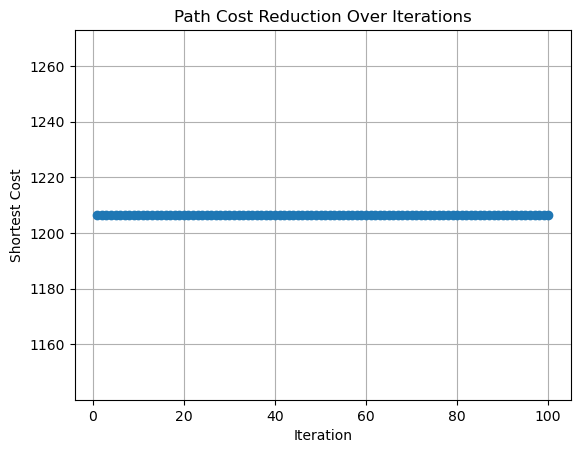

In [34]:
# Initialize a list to track the shortest cost for each iteration
costs_per_iteration = []

for iteration in tqdm(range(num_iterations), desc="ACO Progress"):
    # ... (existing code for path generation and pheromone update)

    # Append the shortest cost for this iteration to the list
    costs_per_iteration.append(shortest_cost)

# Print costs for analysis
print("Path Cost Reduction Over Iterations:")
for i, cost in enumerate(costs_per_iteration, 1):
    print(f"Iteration {i}: Shortest Cost = {cost:.2f}")

# Plot the costs over iterations
plt.figure()
plt.plot(range(1, num_iterations + 1), costs_per_iteration, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Shortest Cost")
plt.title("Path Cost Reduction Over Iterations")
plt.grid(True)
plt.show()



GOR Values Along the Shortest Path:
Point 1: GOR = 165.36
Point 2: GOR = 162.79
Point 3: GOR = 156.60
Point 4: GOR = 154.64
Point 5: GOR = 151.97
Point 6: GOR = 145.61
Point 7: GOR = 149.40
Point 8: GOR = 149.68
Point 9: GOR = 159.12
Point 10: GOR = 156.30
Point 11: GOR = 153.03
Point 12: GOR = 152.35
Point 13: GOR = 148.03
Point 14: GOR = 145.35
Point 15: GOR = 147.76
Point 16: GOR = 147.00
Point 17: GOR = 144.44
Point 18: GOR = 150.76
Point 19: GOR = 153.01
Point 20: GOR = 151.40
Point 21: GOR = 150.16
Point 22: GOR = 150.54
Point 23: GOR = 146.11
Point 24: GOR = 152.68
Point 25: GOR = 155.86
Point 26: GOR = 155.51
Point 27: GOR = 153.66
Point 28: GOR = 153.35
Point 29: GOR = 152.86
Point 30: GOR = 166.74
Point 31: GOR = 152.73
Point 32: GOR = 152.76
Point 33: GOR = 156.54
Point 34: GOR = 162.47
Point 35: GOR = 160.37
Point 36: GOR = 154.65
Point 37: GOR = 153.31
Point 38: GOR = 149.85
Point 39: GOR = 147.82
Point 40: GOR = 147.76
Point 41: GOR = 148.90
Point 42: GOR = 146.26
Point 

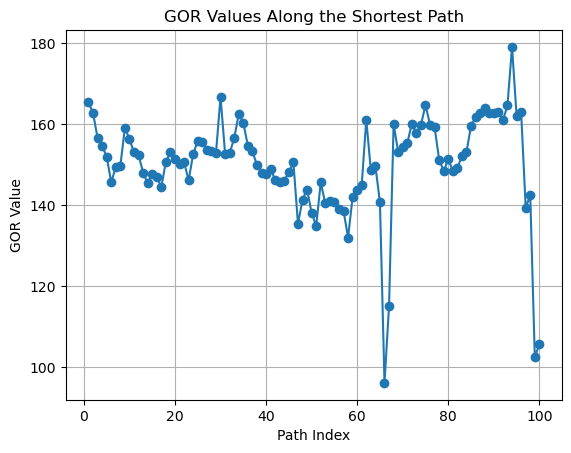

In [36]:
# Print GOR values for each point in the shortest path
print("\nGOR Values Along the Shortest Path:")
for i, gor in enumerate(gor_values, 1):
    print(f"Point {i}: GOR = {gor:.2f}")

# Plot the GOR values along the path
plt.figure()
plt.plot(range(1, len(gor_values) + 1), gor_values, marker='o')
plt.xlabel("Path Index")
plt.ylabel("GOR Value")
plt.title("GOR Values Along the Shortest Path")
plt.grid(True)
plt.show()

In [40]:
# Print feature influence for analysis
print("\nFeature Influence on Path Selection (Based on Pheromone Values):")
for feature, influence in feature_influence.items():
    print(f"{feature}: {influence:.2f}")


Feature Influence on Path Selection (Based on Pheromone Values):
AVG_DOWNHOLE_PRESSURE: 38.33
AVG_DOWNHOLE_TEMPERATURE: 19.05
AVG_ANNULUS_PRESS: 31.60
AVG_CHOKE_SIZE_P: 14.68
Calculated_GOR: 60.20


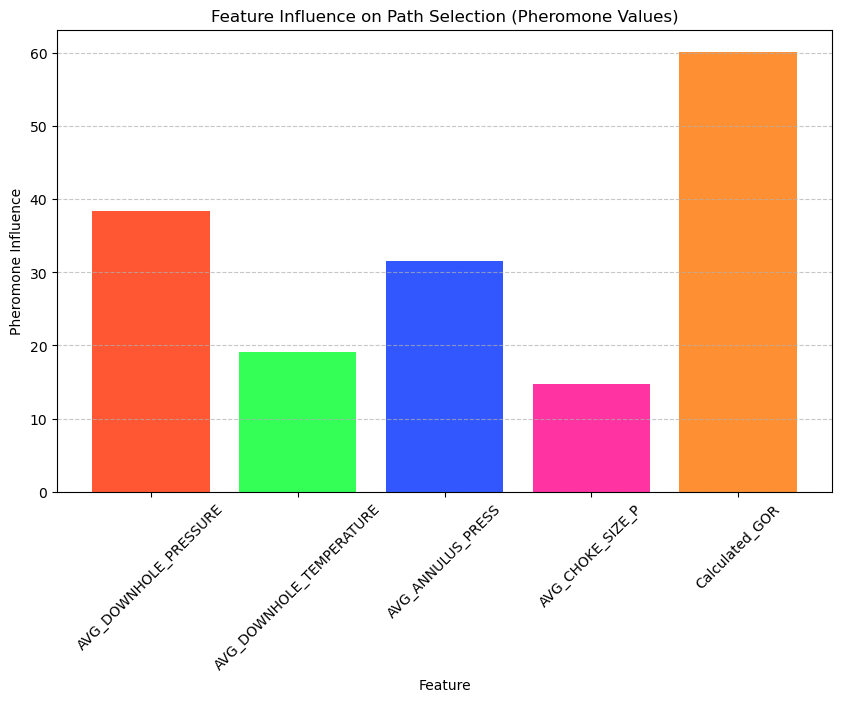

In [44]:
import matplotlib.pyplot as plt

# Define a list of colors for each bar
colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#FF8F33']  # Custom colors for each feature

# Plotting the feature influence
features = list(feature_influence.keys())
influence_values = list(feature_influence.values())

plt.figure(figsize=(10, 6))
plt.bar(features, influence_values, color=colors)  # Apply multiple colors
plt.xlabel("Feature")
plt.ylabel("Pheromone Influence")
plt.title("Feature Influence on Path Selection (Pheromone Values)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: add a light grid for better readability
plt.show()


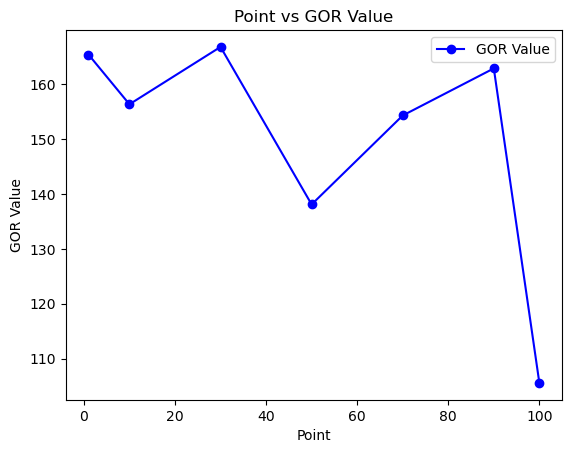

In [47]:
import matplotlib.pyplot as plt

# Data
points = [1, 10, 30, 50, 70, 90, 100]
gor_values = [165.36, 156.30, 166.74, 138.07, 154.26, 162.83, 105.59]

# Plotting the graph
plt.plot(points, gor_values, marker='o', linestyle='-', color='b', label='GOR Value')

# Adding labels and title
plt.xlabel('Point')
plt.ylabel('GOR Value')
plt.title('Point vs GOR Value')

# Displaying the legend
plt.legend()

# Display the plot
plt.show()
